# Brain Tumor Detection
Description
This dataset was originally created by Yousef Ghanem. To see the current project, which may have been updated since this version, please go here: https://universe.roboflow.com/yousef-ghanem-jzj4y/brain-tumor-detection-fpf1f.

This dataset is part of RF100, an Intel-sponsored initiative to create a new object detection benchmark for model generalizability.

Access the RF100 Github repo: https://github.com/roboflow-ai/roboflow-100-benchmark

## Imports

In [1]:
from tqdm.notebook import tqdm

from dotenv import load_dotenv
load_dotenv()

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
tf.config.list_physical_devices('GPU'), tf.__version__

2025-02-14 08:21:45.885790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739521305.897733   13480 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739521305.901299   13480 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-14 08:21:45.915154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [2]:
# auto reload dotenv 
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths Setup

In [3]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_DIR)

datasets/brain-tumor-2/train/


In [4]:
cfg.DATASET_DIRS

{'TRAIN_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/train/', 'VALIDATION_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/valid', 'TEST_DIR': '${DATASET.DATASET_DIR}/${DATASET.DATASET_NAME}/test'}

In [5]:
from pathlib import Path

DATASET_DIRS = Path(cfg.DATASET.DATASET_DIR)
TRAIN_DIR = Path(cfg.DATASET_DIRS.TRAIN_DIR)
VALIDATION_DIR = Path(cfg.DATASET_DIRS.VALIDATION_DIR)
TEST_DIR = Path(cfg.DATASET_DIRS.TEST_DIR)

TRAIN_IMAGE_DIR = TRAIN_DIR / 'images'
TRAIN_LABELS_DIR = TRAIN_DIR / 'labels'

VALID_IMAGE_DIR = VALIDATION_DIR / 'images'
VALID_LABELS_DIR = VALIDATION_DIR / 'labels'

TEST_IMAGE = TEST_DIR / 'images'
TEST_LABELS = TEST_DIR / 'labels'

IMG_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE

CLASS_NAME = [
    'label0',
    'label1',
    'label2'
]

## Dataset Download from Roboflow

In [6]:
if not TRAIN_DIR.exists():
    from roboflow import Roboflow
    rf = Roboflow()
    project = rf.workspace("roboflow-100").project("brain-tumor-m2pbp")
    version = project.version(2)
    dataset = version.download("yolov8")
                

## Load images from directory

In [7]:

from pathlib import Path

import cv2
import numpy as np
import tensorflow as tf
import tqdm
from tqdm.notebook import tqdm


class PrepareDataset:
    def __init__(self, image_dir: Path, label_dir: Path, dst_img_size:tuple[int, int]=(224,224)) -> None:
        """
        Args:
            image_dir (str): Path to the directory containing the images.
            label_dir (str): Path to the directory containing the labels.
        """
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.dst_img_size= dst_img_size


    def get_dataset(self) -> tuple[list[str], np.ndarray, np.ndarray]:
        """Loads and parses YOLOv8 labels.

        Args:
            image_dir: Path to the directory containing images.
            label_dir: Path to the directory containing labels.
            dst_img_size: Tuple (width, height) specifying the desired image size.

        Returns:
            tuple[np.ndarray, np.ndarray, np.ndarray]: A tuple containing:
                - Image data (NumPy array, shape (num_images, height, width, channels)).
                - Class IDs (NumPy array, dtype=np.int32).
                - Bounding boxes (NumPy array, shape (num_images, max_objects, 4), dtype=np.float32).
        """

        images = []
        class_ids = []
        bboxes = []

        for file_name in tqdm(list(self.image_dir.iterdir())[:100]):  # Removed [:100]
            if file_name.suffix.lower() in (".jpg", ".png", ".jpeg"): # Added .jpeg and lower() for robustness
                image_path = file_name
                label_file_path = self.label_dir / f'{file_name.stem}.txt'

                if not label_file_path.exists():
                    print(f"Label file not found for image: {image_path}")
                    continue

                # image = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)
                # if image is None:  # Check if the image was read successfully
                #     print(f"Error reading image: {image_path}")
                #     continue

                # image = cv2.resize(image, self.dst_img_size).astype(np.float32)# / 255.0  # Normalize pixel values
                
                with label_file_path.open('r') as f:
                    lines = f.readlines()

                if not lines:
                    print(f"Label file is empty: {label_file_path}")
                    continue

                for line in lines:
                    try:
                        values = np.array([float(value) for value in line.split()]) # Explicit float conversion
                        class_id = int(values[0])  # Explicit int conversion for class ID
                        coords = values[1:5].astype(np.float32)  # Ensure float32 for coords
                        
                        images.append(str(image_path))
                        bboxes.append(coords)
                        class_ids.append(class_id)

                    except ValueError as e:  # Catch specific ValueError
                        print(f"[ERROR] - {e} in file {label_file_path} on line: {line}")
                        continue
                    except IndexError as e: # Catch potential IndexError
                        print(f"[ERROR] - {e} in file {label_file_path} on line: {line}")
                        continue

        return images, (np.array(class_ids, dtype=np.int8), np.array(bboxes, dtype=np.float32))

In [8]:
# from utils.custom_dataset_loader import CustomDatasetLoader
prepare_train_dataset = PrepareDataset(image_dir=TRAIN_IMAGE_DIR, 
                                    label_dir=TRAIN_LABELS_DIR,
                                    dst_img_size=(IMG_SIZE, IMG_SIZE))

train_images, (train_class_ids, train_bboxes)  = prepare_train_dataset.get_dataset()

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
def convert_coordinates_for_plot(image, bbox):
  x_center, y_center, width, height = bbox
  img_height, img_width = image.shape[:2]
  print(img_height, img_width)
  xmin = int(max(0, (x_center - width / 2) * img_width))  # Clip to 0
  ymin = int(max(0, (y_center - height / 2) * img_height)) # Clip to 0
  xmax = int(min(img_width, (x_center + width / 2) * img_width)) # Clip to image width
  ymax = int(min(img_height, (y_center + height / 2) * img_height))# Clip to image height


  return np.array([xmin, ymin, xmax, ymax], dtype=np.int32)#.reshape(1, 4)


240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240
240 240


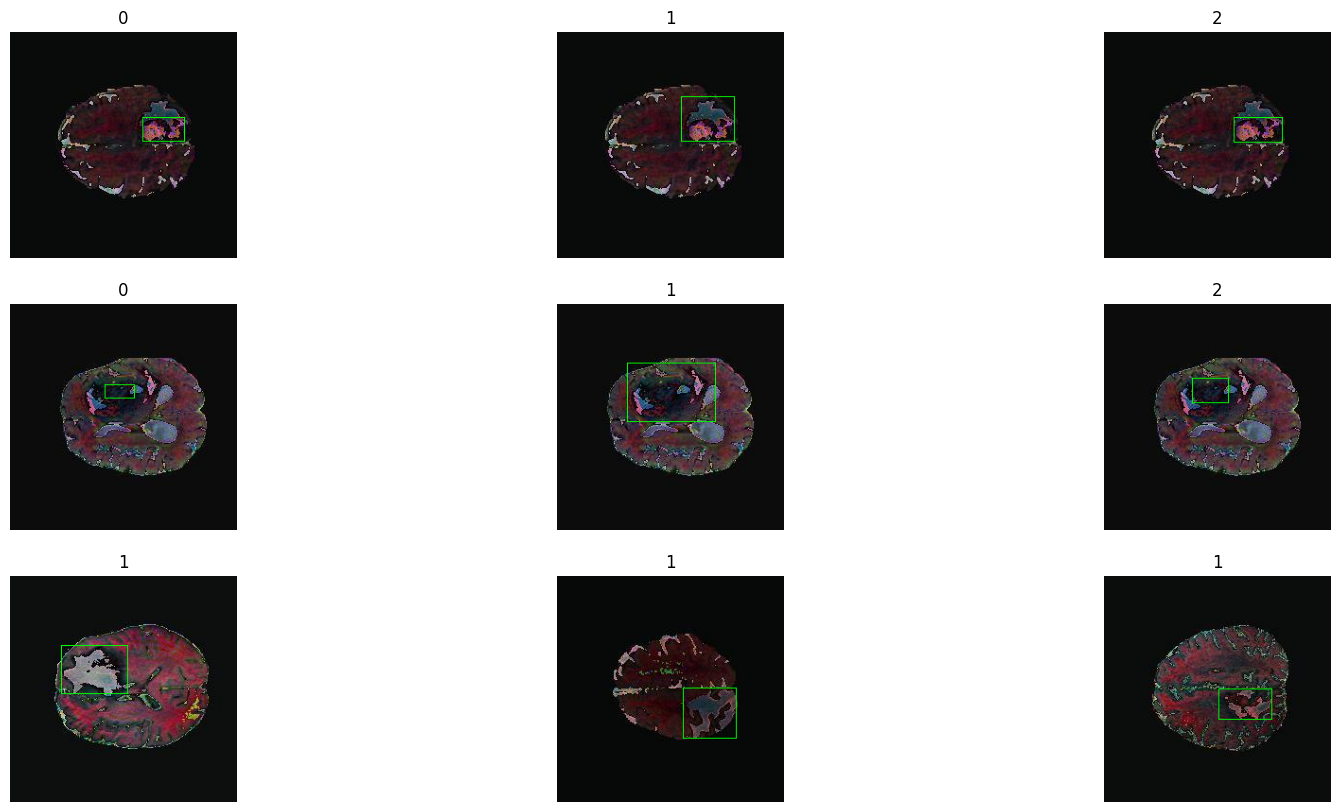

In [10]:
fig = plt.figure(figsize=(20, 10))
for i in range(9):
  ax = fig.add_subplot(3, 3, i+1)
  image_path = train_images[i]
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # print(train_bboxes[i])
  xmin, ymin, xmax, ymax = convert_coordinates_for_plot(image, train_bboxes[i])
  ax.set_title(str(train_class_ids[i]))
  ax.axis('off')
  cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
  plt.imshow(image)